In [1]:
import sys
import copy
import math
from tqdm.notebook import tqdm

progress = 0
total_size = 0
progress_bar = None

def global_emulation( parameters_min, parameters_max, relative_error, acceptable_error, max_depth, depth, recurse, baseline_points, perturbed_points, test_points, extra_points, regions, baselines, gradients, errors ):
#     if not recurse:
#         print( str( parameters_min ) + '\t' + str( parameters_max ) )
    
    points = []
    baseline = function( parameters_min )
    predicted = baseline
    
    parameters = copy.deepcopy(parameters_min)
    
    gradient = []
    
    for i in range( len(parameters_min) ):
        parameters[i] = parameters_min[i] + ( parameters_max[i] - parameters_min[i] ) / 2
        
        perturbed = function( parameters )
        
        predicted += ( perturbed - baseline ) * 2
#         predicted += ( function( parameters ) - baseline ) / 2
        points.append( tuple( parameters ) )
        
        gradient.append( 2 * ( perturbed - baseline ) / ( parameters_max[i] - parameters_min[i] ) )
        
        parameters[i] = parameters_min[i]
    
    for i in range( len(parameters_min) ):
        parameters[i] = parameters_max[i] # + ( parameters_max[i] - parameters_min[i] ) / 2
    
    actual = function( parameters )
    test_points.append( tuple( parameters ) )
    
#     for i in range( len(parameters_min) ):
#         parameters[i] = parameters_max[i]
    
    error = abs( actual - predicted )
    if relative_error:
         error /= abs( actual )
    
    if error <= acceptable_error or depth == max_depth or not recurse:
        if recurse:
            baseline_points.append( tuple( parameters_min ) )
            region = []
            region.extend( parameters_min )
            region.extend( parameters_max )
            regions.append( tuple( region ) )
            baselines.append( baseline )
            gradients.append( gradient )
#             if parameters_min[0] == 0.5 and parameters_min[1] == 0.5:
#                 print( gradient )
            errors.append( error )
            perturbed_points.extend( points )            
        
            size = 1
            for i in range( len(parameters_min) ):
                size *= ( parameters_max[i] - parameters_min[i] )
            
            progress_bar.update( size / total_size )            
        else:
            extra_points.append( tuple( parameters_min ) )
            extra_points.extend( points )
            
        return error
    
    extra_points.append( tuple( parameters_min ) )
    extra_points.extend( points )
    
    reduction = None
    best = -1
    
    for i in range( len(parameters_min) ):
        parameters[i] = parameters_min[i] + ( parameters_max[i] - parameters_min[i] ) / 2
        
        new_error = global_emulation(parameters_min, parameters, relative_error, acceptable_error, max_depth, depth, False, baseline_points, perturbed_points, test_points, extra_points, regions, baselines, gradients, errors)
        
        parameters[i] = parameters_max[i]
        
        if reduction is None or new_error < reduction:
            reduction = new_error
            best = i
    
#     print( parameters_min )
#     print( parameters_max )
#     print( str(actual) + '\t' + str(predicted) )
#     print( str(error) + '\t' + str(reduction) )
#     print( '' )
    
    saved_parameter_max = parameters_max[best]
    
    parameters_max[best] = parameters_min[best] + ( parameters_max[best] - parameters_min[best] ) / 2
    
    global_emulation(parameters_min, parameters_max, relative_error, acceptable_error, max_depth, depth + 1, True, baseline_points, perturbed_points, test_points, extra_points, regions, baselines, gradients, errors)
    
    parameters_max[best] = saved_parameter_max
    
    saved_parameter_min = parameters_min[best]
    
    parameters_min[best] = parameters_min[best] + ( parameters_max[best] - parameters_min[best] ) / 2
    
    global_emulation(parameters_min, parameters_max, relative_error, acceptable_error, max_depth, depth + 1, True, baseline_points, perturbed_points, test_points, extra_points, regions, baselines, gradients, errors)
    
    parameters_min[best] = saved_parameter_min

In [2]:
# Here, we define the SIR and SEIRP models.

from scipy.integrate import odeint

seirp_parameters = { }
parameters_to_use = []

def function( parameters ):
    if len( seirp_parameters ) > 0:
        return seirp( parameters )
    else:
        return sir( parameters )

# SEIRP Model
def seirp( parameters ):
    Ip0 = 500000
    S0 = 6300000
    E0 = 100
    I0 = 50
    R0 = 0
    Rp0 = 0
    
    r = seirp_parameters['r']
    rp = seirp_parameters['rp']
    alpha = seirp_parameters['alpha']
    sigma = seirp_parameters['sigma']
    beta = seirp_parameters['beta']
    
    for i in range( len( parameters_to_use) ):    
        if parameters_to_use[i] == 'r':
            r = parameters[i]
        if parameters_to_use[i] == 'rp':
            rp = parameters[i]
        if parameters_to_use[i] == 'alpha':
            alpha = parameters[i]
        if parameters_to_use[i] == 'beta':
            beta = parameters[i]
        if parameters_to_use[i] == 'sigma':
            sigma = parameters[i]
        
    def deriv(y, t, r, rp, beta, alpha, sigma):
        S, E, I, R, Ip, Rp = y
        N = S + E + I + R + Ip + Rp
        dSdt = -r * (S * I)/N - rp * (S * Ip)/N
        dEdt = r * (S * I)/N - beta * E
        dIdt = beta * E - alpha * I
        dRdt = alpha * I
        dIpdt = rp * (S * Ip)/N - sigma * Ip
        dRpdt = sigma * Ip
        return dSdt, dEdt, dIdt, dRdt, dIpdt, dRpdt

    y0 = S0, E0, I0, R0, Ip0, Rp0

    tmin = 0
    tmax = 201
    t = list(range(tmin, tmax))

    ret = odeint(deriv, y0, t, args=(r, rp, beta, alpha, sigma))
    S, E, I, R, Ip, Rp = ret.T

    return R[200]

# SIR Model
def sir( parameters ):
    S0 = 0.99
    I0 = 0.01
    R0 = 0
    beta = parameters[0]
    gamma = parameters[1]

    def deriv(y, t, beta, gamma):
        S, I, R = y
        dSdt = -beta * (S * I)
        dIdt = beta * (S * I) - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt

    y0 = S0, I0, R0

    tmin = 0
    tmax = 201
    t = list(range(tmin, tmax))

    ret = odeint(deriv, y0, t, args=(beta, gamma))
    S, I, R = ret.T
    
    return R[200]

In [3]:
# Here, we perform the emulation.

baseline_points = []
perturbed_points = []
test_points = []
extra_points = []
regions = []
baselines = []
gradients = []
errors = []

# Use the lines below to emulate the SIR model:
parameters_to_use = [ 'beta', 'gamma' ]
parameters_min = [ 0.1, 0.1 ]
parameters_max = [ 0.9, 0.9 ]
relative_error = False
acceptable_error = 0.01
max_depth = 15

# Use the lines below to emulate the SEIRP model:
# seirp_parameters = { 'r' : 0.6929, 'rp' : 0.4808, 'alpha' : 0.47, 'sigma' : 0.461, 'beta' : 0.103 }
# parameters_to_use = [ 'r', 'alpha', 'beta', 'rp', 'sigma' ] # For parameters that are in seirp_parameters, but not in parameters_to_use, the parameter will be fixed to the value given in seirp_parameters.
# parameters_min = [ 0.1, 0.1, 0.1, 0.1, 0.1 ]
# parameters_max = [ 0.9, 0.9, 0.9, 0.9, 0.9 ]
# relative_error = True
# acceptable_error = 0.01
# max_depth = 15

progress = 0
total_size = 1
progress_bar = tqdm(total=1.0)

for i in range( len(parameters_min) ):
    total_size *= ( parameters_max[i] - parameters_min[i] )

# sys.setrecursionlimit(10000)

global_emulation( parameters_min, parameters_max, relative_error, acceptable_error, max_depth, 0, True, baseline_points, perturbed_points, test_points, extra_points, regions, baselines, gradients, errors)

all_points = []
all_points.extend(baseline_points)
all_points.extend(perturbed_points)
all_points.extend(test_points)
all_points.extend(extra_points)

all_points_set = set(all_points)

print( str( len(all_points_set) ) + ' / ' + str( len(all_points) ) )

# baseline_points_set = set(baseline_points)
# perturbed_points_set = set(perturbed_points)
# test_points_set = set(test_points)
# extra_points_set = set(extra_points)

# perturbed_points_set = perturbed_points_set - baseline_points_set
# test_points_set = test_points_set - baseline_points_set
# test_points_set = test_points_set - perturbed_points_set
# extra_points_set = extra_points_set - baseline_points_set
# extra_points_set = extra_points_set - perturbed_points_set
# extra_points_set = extra_points_set - test_points_set

# baseline_points_set_list = list(baseline_points_set)
# perturbed_points_set_list = list(perturbed_points_set)
# test_points_set_list = list(test_points_set)
# extra_points_set_list = list(extra_points_set)

# for k in range( max( len(baseline_points_set_list), len(perturbed_points_set_list), len(test_points_set_list), len(extra_points_set_list) ) ):
#     row = ''
#     if k < len(baseline_points_set_list):
#         point = baseline_points_set_list[k]
#         row += str(point[0]) + '\t' + str(point[1]) + '\t'
#     else:
#         row += '\t\t'
#     if k < len(perturbed_points_set_list):
#         point = perturbed_points_set_list[k]
#         row += str(point[0]) + '\t' + str(point[1]) + '\t'
#     else:
#         row += '\t\t'
#     if k < len(test_points_set_list):
#         point = test_points_set_list[k]
#         row += str(point[0]) + '\t' + str(point[1]) + '\t'
#     else:
#         row += '\t\t'
#     if k < len(extra_points_set_list):
#         point = extra_points_set_list[k]
#         row += str(point[0]) + '\t' + str(point[1]) + '\t'
#     else:
#         row += '\t\t'

#     print(row)


  0%|          | 0/1.0 [00:00<?, ?it/s]

677 / 2644


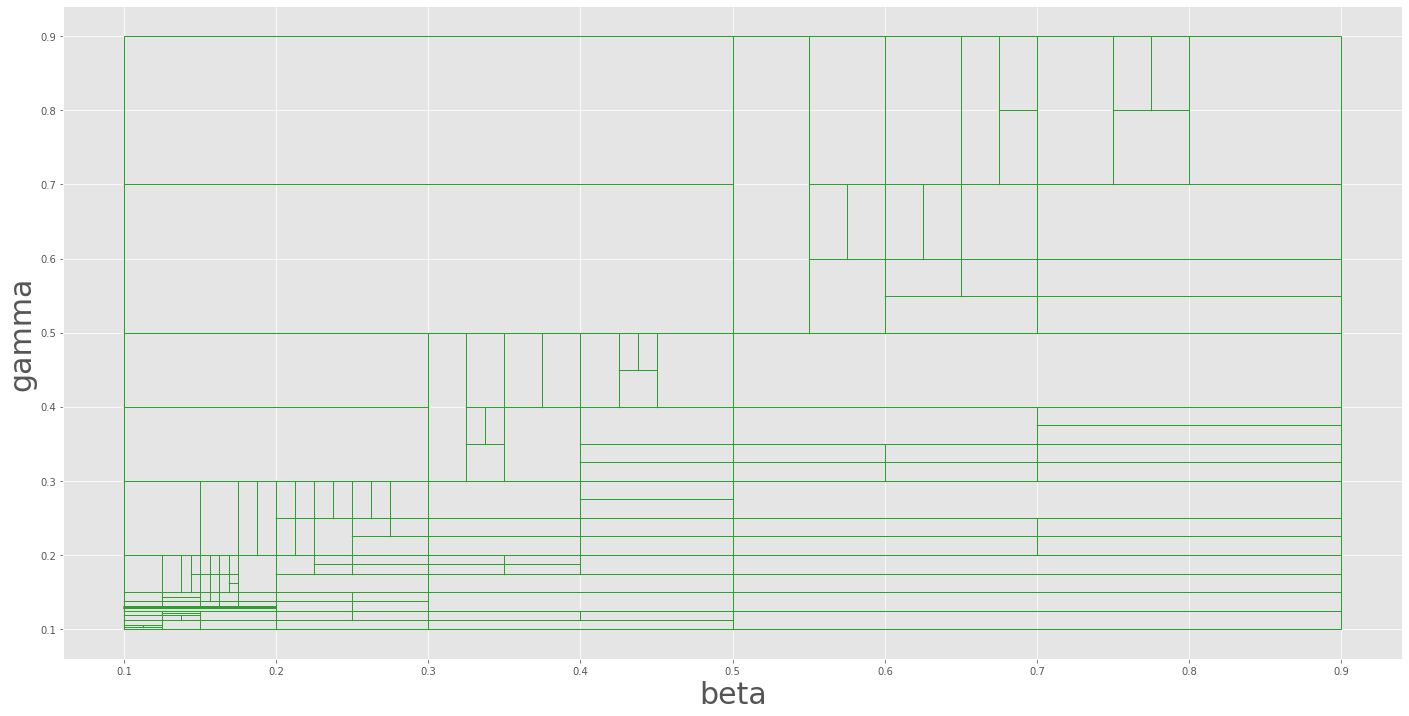

Region Boundary: (0.1, 0.1, 0.125, 0.10312500000000001)
Equation: output = 9.209563200470313 * beta - 6.080993989792093 * gamma + 0.11967053217550297

Region Boundary: (0.1, 0.10312500000000001, 0.1125, 0.10625000000000001)
Equation: output = 6.747575446825868 * beta - 4.866692553002161 * gamma + 0.10165945245621968

Region Boundary: (0.1125, 0.10312500000000001, 0.125, 0.10625000000000001)
Equation: output = 10.779891299661147 * beta - 9.908969564156935 * gamma + 0.2007104287032451

Region Boundary: (0.1, 0.10625000000000001, 0.125, 0.1125)
Equation: output = 6.684731476950672 * beta - 3.661989107043007 * gamma + 0.08726993177932425

Region Boundary: (0.125, 0.1, 0.15000000000000002, 0.1125)
Equation: output = 9.68622405345136 * beta - 12.38086725659429 * gamma + 0.3773614409548135

Region Boundary: (0.1, 0.1125, 0.125, 0.11875)
Equation: output = 4.578457785218428 * beta - 2.329192082997703 * gamma + 0.06672037876237291

Region Boundary: (0.125, 0.1125, 0.1375, 0.11875)
Equation: out

In [4]:
# Here, we plot the regions of the parameter space, as partitioned by the emulation algorithm.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

points_to_plot = np.array( baseline_points )
points_to_plot = np.transpose( points_to_plot )

plt.style.use('ggplot')
plt.figure(figsize=(24,12))
plt.xlabel(parameters_to_use[0], fontsize=30)
plt.ylabel(parameters_to_use[1], fontsize=30)
plt.scatter( points_to_plot[0], points_to_plot[1], s=1 ) # We need this in order to automatically set the axis bounds.

# fig, ax = plt.subplots()
for ( region, gradient ) in zip( regions, gradients ):
    color = None
    if gradient[0] >= 0 and gradient[1] >= 0:
        color = 'r'
    if gradient[0] >= 0 and gradient[1] <= 0:
        color = 'tab:green'
    if gradient[0] <= 0 and gradient[1] >= 0:
        color = 'tab:purple'
    if gradient[0] <= 0 and gradient[1] <= 0:
        color = 'b'
    plt.gca().add_patch(Rectangle( ( region[0], region[1] ), ( region[ round( len(region) / 2 ) ] - region[0] ), ( region[ round( len(region) / 2 ) + 1 ] - region[1] ), linewidth=1, edgecolor=color, facecolor='none'))

plt.show()

equations_to_print = 10
equation_count = 0

for ( region, baseline, gradient ) in zip( regions, baselines, gradients ):
    if equation_count >= equations_to_print:
        break
    equation_count += 1
    
    equation = 'output = '
    
    for j in range( len(gradient) ):
        if j == 0:
            equation += str(gradient[j]) + ' * ' + parameters_to_use[j]
        elif gradient[j] >= 0:
            equation += ' + ' + str(gradient[j]) + ' * ' + parameters_to_use[j]
        else:
            equation += ' - ' + str(-gradient[j]) + ' * ' + parameters_to_use[j]
        
    equation += ' + ' + str(baseline)
    
    print( 'Region Boundary: ' + str(region) )
    print( 'Equation: ' + equation )
    print( '' )

  0%|          | 0/166 [00:00<?, ?it/s]

Number of regions: 166
Number of regions that should have been subdivided further: 16
Proportion of the parameter space that should have been subdivided further: 0.0004882812500000026
Expected error: 0.011047236582235331 (absolute), 0.11284098124706461 (relative)
Median error: 0.004501319542417059 (absolute), 0.04218681395899985 (relative)
Maximum error: 0.09631637908714935 (absolute), 2.2007850175731196 (relative)


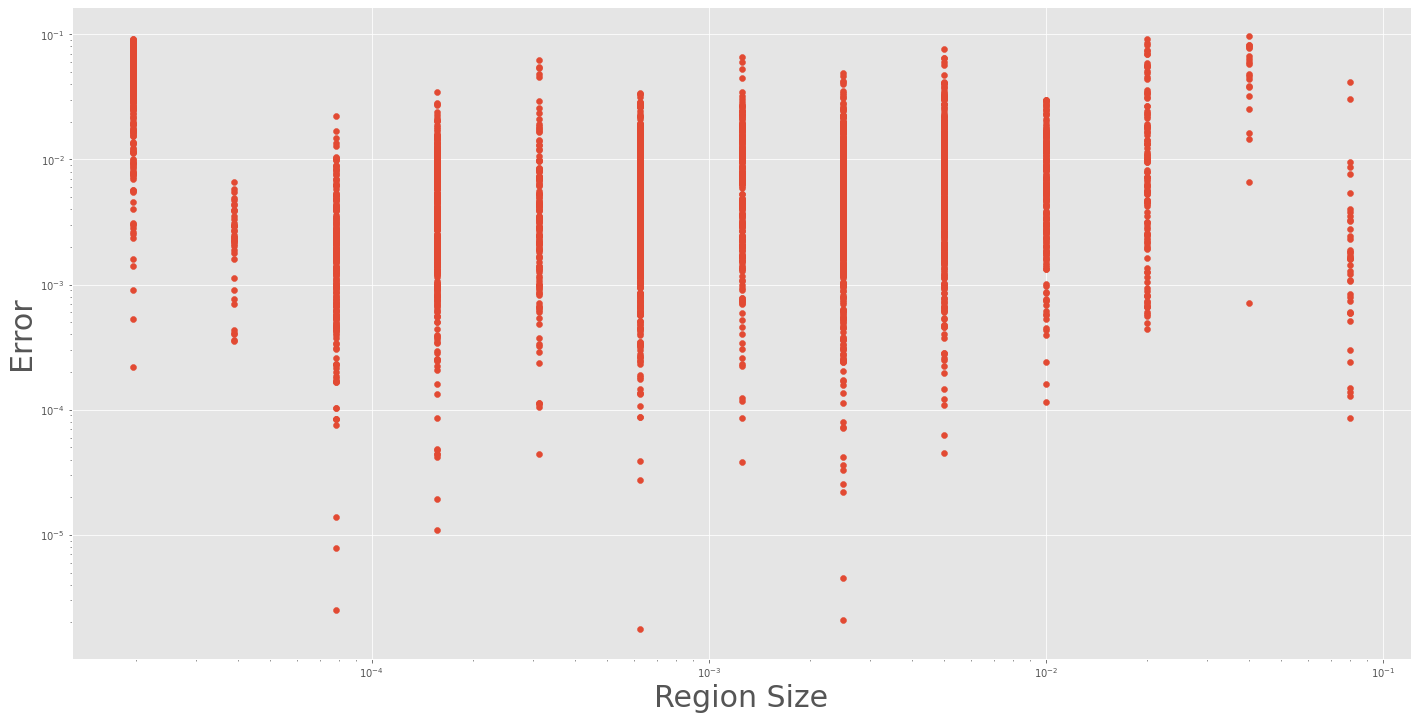

0.9999999999999999


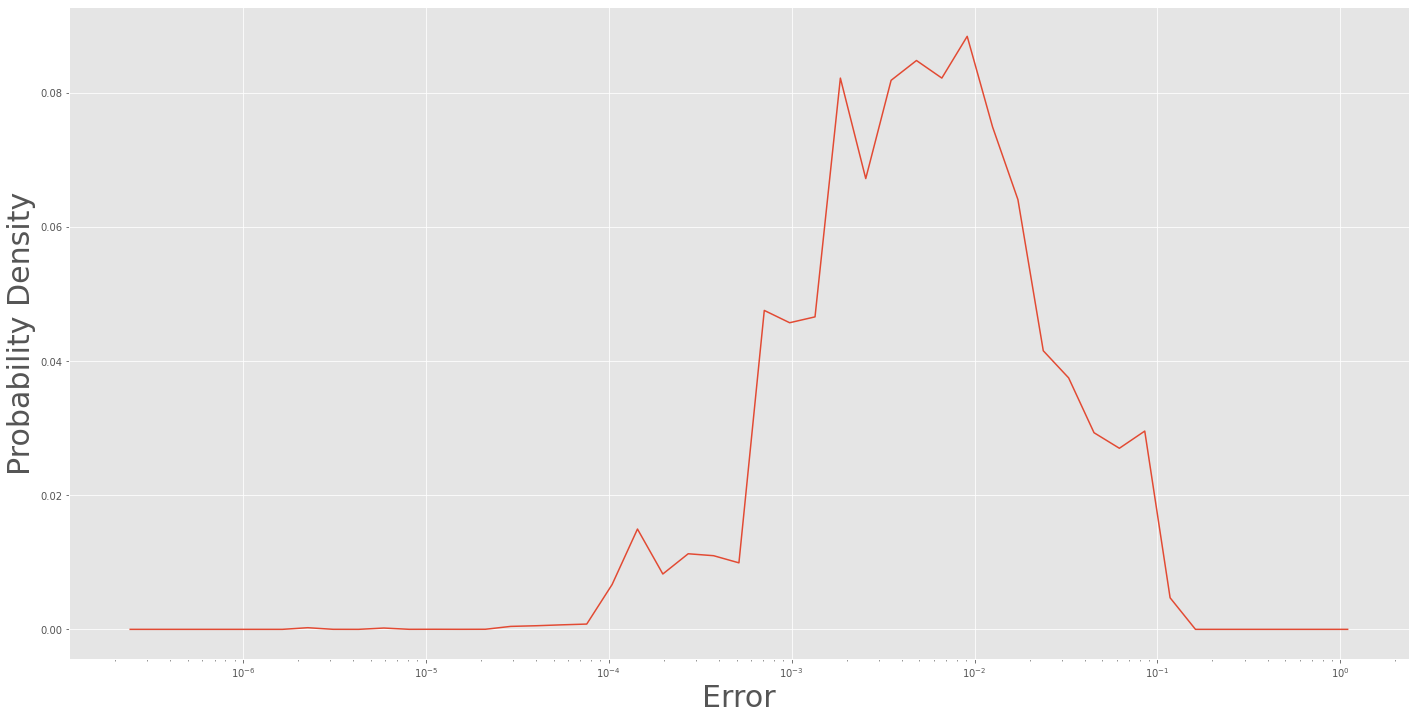

In [5]:
# Here, we approximate the distribution of emulation errors across the parameter space.

# import numpy as np
# import matplotlib.pyplot as plt
import random
import statistics

plt.style.use('ggplot')

duplicated_errors = []
duplicated_errors_relative = []
test_errors = []
test_errors_relative = []
expected_error = 0
expected_error_relative = 0
regions_needing_further_subdivision = 0
space_needing_further_subdivision = 0

points_per_region = 20

random.seed(1)

progress_bar_2 = tqdm(total=len(regions))

region_sizes = []
for ( region, baseline, gradient, error ) in zip( regions, baselines, gradients, errors ):
    region_size = 1
    for j in range( round( len(region) / 2 ) ):
        region_size *= ( region[j + round( len(region) / 2 )] - region[j] )
                
    if error > acceptable_error:
        regions_needing_further_subdivision += 1
        space_needing_further_subdivision += region_size / total_size

    for i in range( points_per_region ):
        region_sizes.append(region_size)

        test_parameters = []
        test_predicted = baseline

        for j in range( round( len(region) / 2 ) ):
            test_perturbation = ( region[j + round( len(region) / 2 )] - region[j] ) * random.uniform(0, 1)
            test_predicted += test_perturbation * gradient[j]
            test_parameters.append( region[j] + test_perturbation )

        test_actual = function( test_parameters )

        test_error = abs( test_actual - test_predicted )
        test_error_relative = test_error / abs( test_actual )

        test_errors.append( test_error )
        test_errors_relative.append( test_error_relative )

        expected_error += region_size * test_error / total_size
        expected_error_relative += region_size * test_error_relative / total_size
        
#         print( str(test_actual) + '\t' + str(test_predicted) + '\t' + str(test_error) + '\t' + str(test_error_relative) )

        duplicated_errors.extend( [ test_error ] * round( ( region_size * ( 2 ** max_depth ) / total_size ) ) )
        duplicated_errors_relative.extend( [ test_error_relative ] * round( ( region_size * ( 2 ** max_depth ) / total_size ) ) )
    
    progress_bar_2.update(1)
    
expected_error /= points_per_region
expected_error_relative /= points_per_region

print( 'Number of regions: ' + str(len(regions)) )
print( 'Number of regions that should have been subdivided further: ' + str(regions_needing_further_subdivision) )
print( 'Proportion of the parameter space that should have been subdivided further: ' + str(space_needing_further_subdivision) )
print( 'Expected error: ' + str(expected_error) + ' (absolute), ' + str(expected_error_relative) + ' (relative)' )
print( 'Median error: ' + str(statistics.median(duplicated_errors)) + ' (absolute), ' + str(statistics.median(duplicated_errors_relative)) + ' (relative)' )
print( 'Maximum error: ' + str(max(test_errors)) + ' (absolute), ' + str(max(test_errors_relative)) + ' (relative)' )

plt.figure(figsize=(24,12))
plt.xlabel('Region Size', fontsize=30)
plt.ylabel('Error', fontsize=30)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')

plt.scatter( region_sizes, test_errors )

plt.show()

# TODO: If emulation error is 0, then we will end up taking the logarithm of 0, which is a problem.
bins = np.logspace( np.log10( min( duplicated_errors ) ) - 1, np.log10( max( duplicated_errors ) + 1 ) ) # We subtract/add 1 in case of numerical precision errors, which could result in the minimum/maximum error not being included in the histogram.
bins[0] = 0
hist, bins = np.histogram( duplicated_errors, bins )
# TODO: Perhaps we should plot hist against the midpoint of each bin, not against the boundaries between adjacent bins?
bins = bins[1:]

hist = hist / ( 2 ** max_depth )
hist = hist / points_per_region

print( sum(hist) )

plt.figure(figsize=(24,12))
plt.xlabel('Error', fontsize=30)
plt.ylabel('Probability Density', fontsize=30)
ax = plt.gca()
# ax.set_yscale('log')
ax.set_xscale('log')
plt.plot( bins, hist )